# CS4035 - Cyber Data Analytics
## Lab 3 

## Group Number: 69

## Student 1 
### Name : Konrad Ponichtera
### ID : 5580749

## Student 2
### Name : Ion Babalau
### ID : 5626110

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbformat
from hashlib import md5

from flexfringe import FlexFringe
from scipy.spatial.distance import cosine

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix


/var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/ipykernel_8892/3105787470.py:8: RuntimeWarning: Could not find dot executable in path. Displaying graphs will not work. Please install graphviz: https://graphviz.org/download/
  from flexfringe import FlexFringe


In [2]:
nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 804


## README

Expected location of dataset: _data_ directory, in same directory as notebook. 
All the necessary packages are specifeid in _requirements.txt_, and can be installed with the command: `pip install -r requirements.txt`
Also, indicate the flexfringe executable path in the flexfringe_path variable

In [3]:
flexfringe_path = "/Users/ionbabalau/uni/q4/FlexFringe/flexfringe"

## 1. Familiarization and discretization task – 1 A4 (5 Points)

### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [4]:
df = pd.read_csv("data/dataset_10/capture20110818.binetflow")

infected_hosts = [
'147.32.84.165',
'147.32.84.191',
'147.32.84.192',
'147.32.84.193',
'147.32.84.204',
'147.32.84.205',
'147.32.84.206',
'147.32.84.207',
'147.32.84.208',
'147.32.84.209'
]

print('Dataset size:', len(df))

df.head()

Dataset size: 1309791


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


### Analyzing labels

In [5]:
def filter_benign(df):
    return df[~df['SrcAddr'].isin(infected_hosts)]

def filter_infected(df):
    return df[df['SrcAddr'].isin(infected_hosts)]

In [6]:
df_benign = filter_benign(df)
df_infected = filter_infected(df)

print('Data entries count:', len(df))
print('Data entries count from benign hosts:', len(df_benign))
print('Data entries count from infected hosts:', len(df_infected))

Data entries count: 1309791
Data entries count from benign hosts: 1203426
Data entries count from infected hosts: 106365


In [7]:
df_benign.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


In [8]:
df_infected.head()
#df_infected.Label.unique()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
90622,2011/08/18 10:37:58.448307,0.000342,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,203,64,flow=From-Botnet-V51-1-UDP-DNS
90808,2011/08/18 10:38:00.695278,0.010278,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,590,87,flow=From-Botnet-V51-1-UDP-DNS
90809,2011/08/18 10:38:00.706560,0.043726,tcp,147.32.84.165,1027,->,74.125.232.206,80,SRPA_SPA,0.0,0.0,7,882,629,flow=From-Botnet-V51-1-TCP-HTTP-Google-Net-Est...
90965,2011/08/18 10:38:03.255934,0.010256,udp,147.32.84.165,1025,<->,147.32.80.9,53,CON,0.0,0.0,2,479,76,flow=From-Botnet-V51-1-UDP-DNS
90968,2011/08/18 10:38:03.267222,581.516663,udp,147.32.84.165,123,->,65.55.56.40,123,INT,0.0,NaN,4,360,360,flow=From-Botnet-V51-1-UDP-Attempt


### Visualizing features

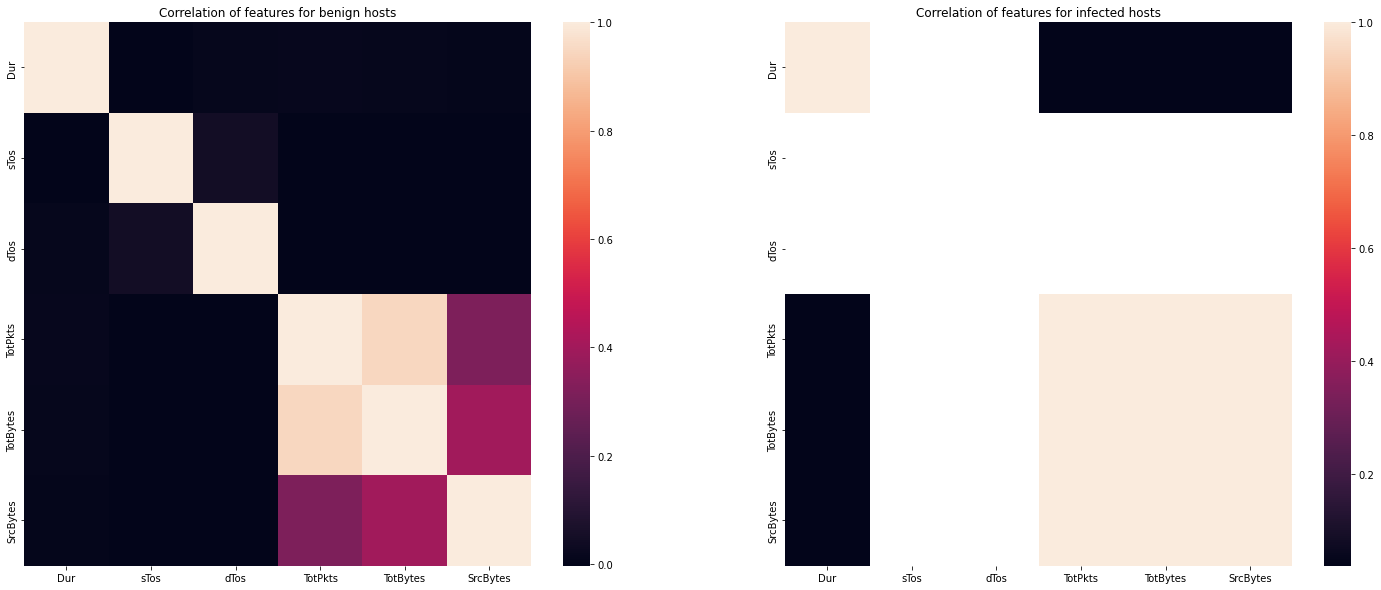

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

ax1.set_title('Correlation of features for benign hosts')
sns.heatmap(df_benign.corr(), ax=ax1)

ax2.set_title('Correlation of features for infected hosts')
sns.heatmap(df_infected.corr(), ax=ax2)

plt.show()

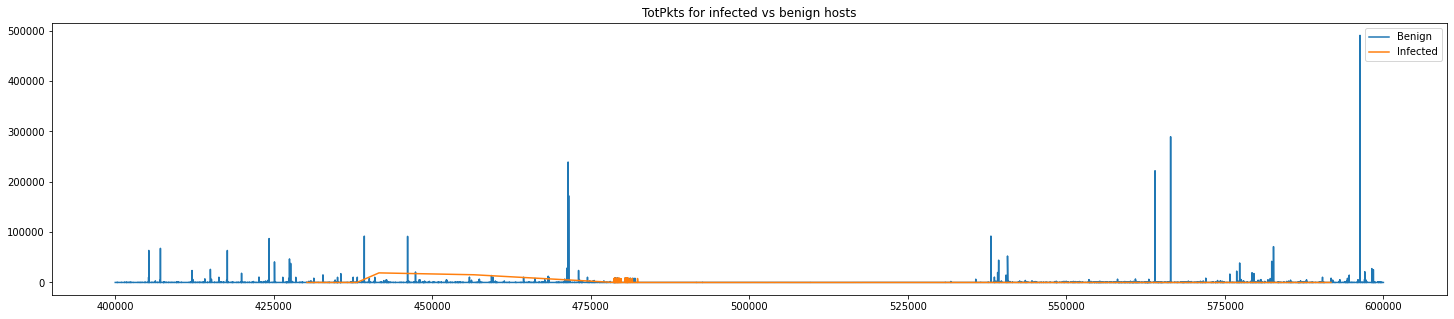

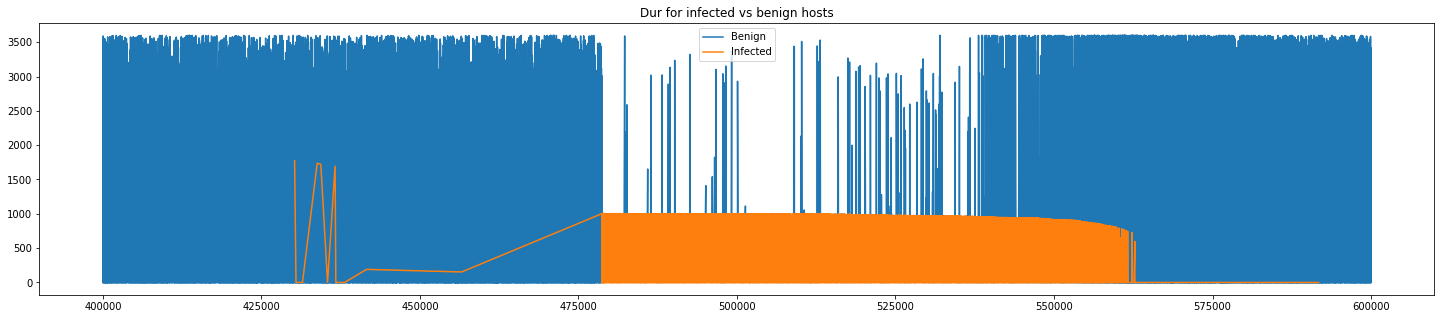

In [10]:
features = ['TotPkts', 'Dur']

df_fragment = df[400000:600000]

df_fragment_infected = filter_infected(df_fragment)
df_fragment_benign = filter_benign(df_fragment)

_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df_fragment_benign[features[0]])
ax.plot(df_fragment_infected[features[0]])
ax.set_title(features[0] + ' for infected vs benign hosts')
ax.legend(labels=['Benign', 'Infected'])
plt.show()

_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(df_fragment_benign[features[1]])
ax.plot(df_fragment_infected[features[1]])
ax.set_title(features[1] + ' for infected vs benign hosts')
ax.legend(labels=['Benign', 'Infected'])
plt.show()


### 1b. Discretize selected features

In [11]:
def discretize(discretizer, feature_array):
    """
    Discretizes the passed data.

    Arguments:
        discretizer: Discretizer, fitted with the learning data
        feature_array: Numpy array with data to discretize, using the passed discretizer
    Returns:
        Discretized data, passed as feature_array argument
    """
    bins = discretizer.transform(feature_array)[:, 0]
    vectorizer = np.vectorize(lambda x: int(discretizer.bin_edges_[0][int(x)]))

    return vectorizer(bins)

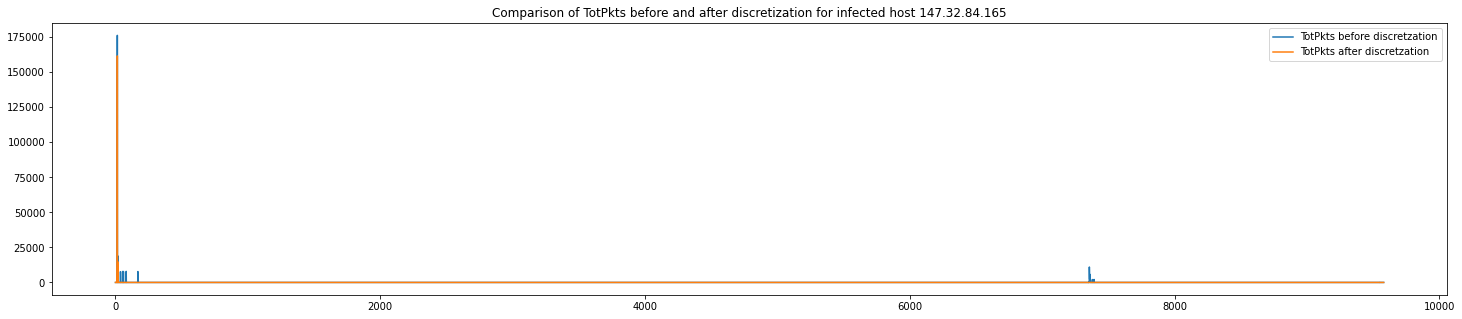

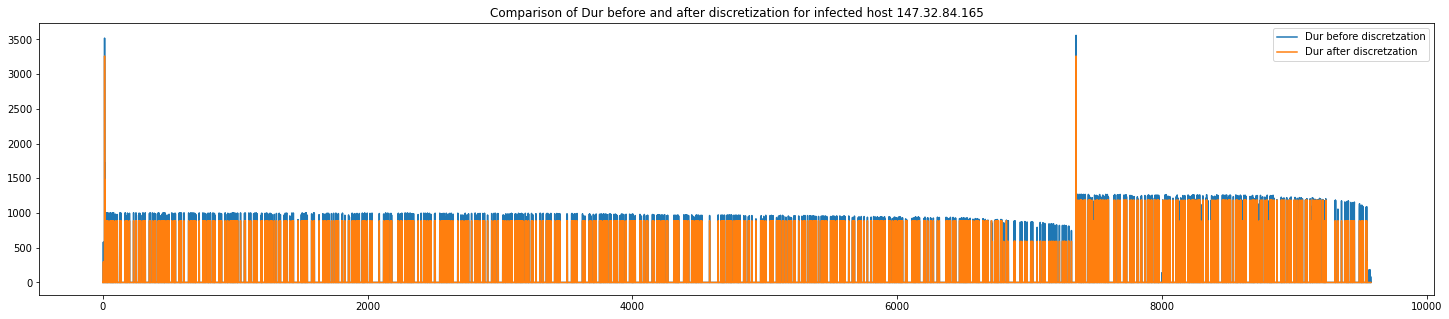

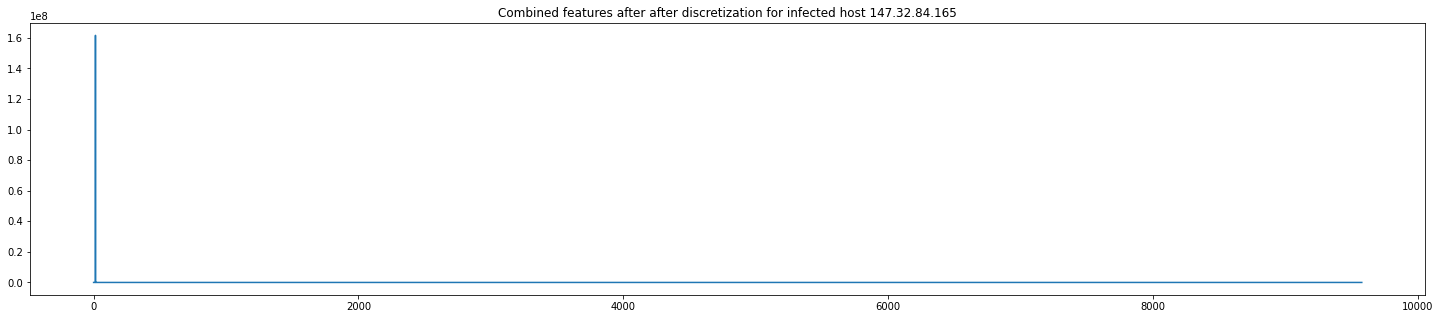

In [12]:
# Ignoring the FutureWarning which is internally thrown by NearestNeighbors
#warnings.simplefilter(action='ignore', category=UserWarning)
# choose a host

host = '147.32.84.165'
df_host = df[df['SrcAddr'] == host]
features_combined = np.zeros(len(df_host[[features[0]]]))

for i in range(len(features)):
    discretizer = KBinsDiscretizer(n_bins=12, strategy='uniform', encode='ordinal')
    df_feature = df_host[[features[i]]].to_numpy()
    discretizer.fit(df_feature)
    feature_discretized = discretize(discretizer, df_feature)
    if i == 0:
        features_combined = list(map(str, feature_discretized))
    else:
        temp = list(map(str, feature_discretized))
        for j in range(len(features_combined)):
            features_combined[j] += temp[j]
    _, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax.plot(df_feature)
    ax.plot(feature_discretized)
    ax.legend(labels=[f'{features[i]} before discretzation', f'{features[i]} after discretzation'], loc='upper right')
    ax.set_title(f'Comparison of {features[i]} before and after discretization for infected host 147.32.84.165') 
    plt.show()

features_combined = np.asarray(list(map(int, features_combined)))
_, ax = plt.subplots(1, 1, figsize=(25, 5))
#ax.set_ylim([None, 20])
ax.plot(features_combined)
ax.set_title(f'Combined features after after discretization for infected host 147.32.84.165') 
plt.show()

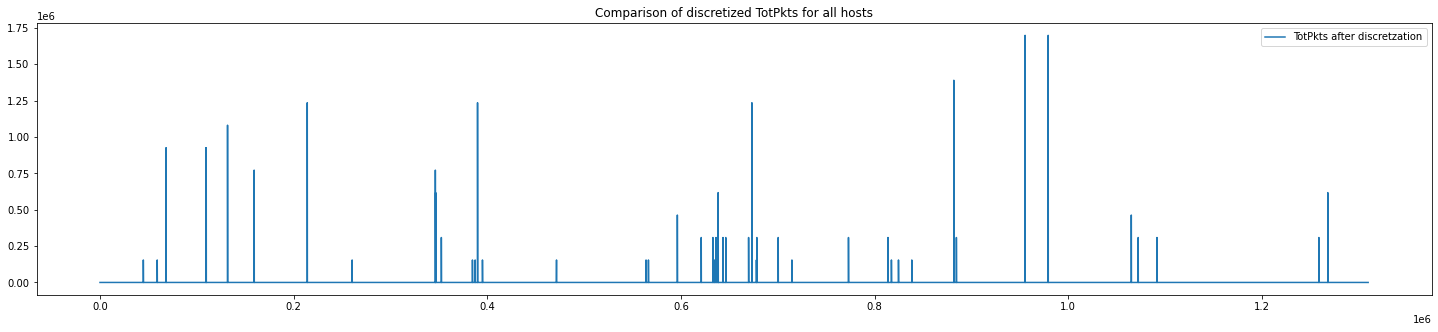

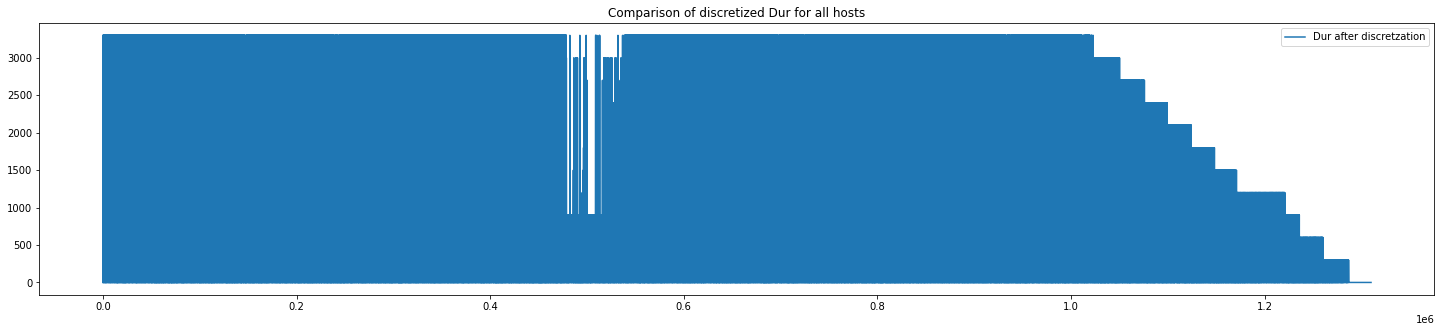

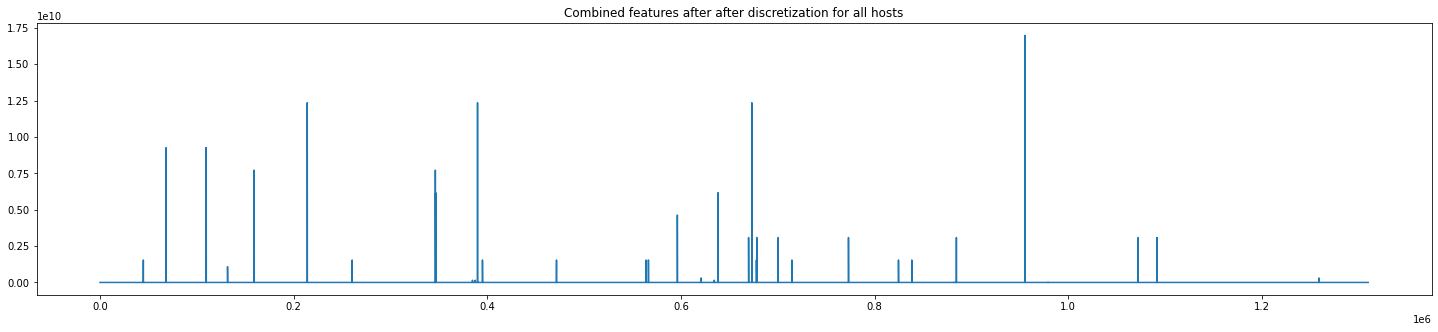

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,TotPkts_Dur
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt,10
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt,10
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established,10
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt,10
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt,10


In [13]:
# applying to all hosts
comb_col_name = features[0] + '_' + features[1]
features_combined = np.zeros(len(df[[features[0]]]))

for i in range(len(features)):
    discretizer = KBinsDiscretizer(n_bins=12, strategy='uniform', encode='ordinal')
    df_feature = df[[features[i]]].to_numpy()
    bins = discretizer.fit_transform(df_feature)[:, 0]
    vectorizer = np.vectorize(lambda x: int(discretizer.bin_edges_[0][int(x)]))
    feature_discretized = vectorizer(bins)
    if i == 0:
        features_combined = list(map(str, feature_discretized))
    else:
        temp = list(map(str, feature_discretized))
        for j in range(len(features_combined)):
            features_combined[j] += temp[j]
    _, ax = plt.subplots(1, 1, figsize=(25, 5))
    ax.plot(feature_discretized)
    ax.legend(labels=[f'{features[i]} after discretzation'], loc='upper right')
    ax.set_title(f'Comparison of discretized {features[i]} for all hosts')
    plt.show()

features_combined = np.asarray(list(map(int, features_combined)))
df[comb_col_name] = features_combined
_, ax = plt.subplots(1, 1, figsize=(25, 5))
ax.plot(features_combined)
ax.set_title(f'Combined features after after discretization for all hosts') 
plt.show()
df.head()

### 1c. Answers and explanation

Firstly, hen analyzing the correlation plots for benign and infected traffic, we notice that for the infected hosts, the correlation between the number of packets and the number of bytes sent is higher. This might mean that each packet sent by an infected host had a similar size, so sending more packets also resulted in more bytes.

Secondly, when analyzing Duration and TotPkts for infected vs normal hosts, we can see that infected hosts usually have lower and more constant values for these features, whereas normal ones tend to spike more.

For creating a combined feature, we have chosen TotPkts and Duration fields. We discretize each feature independently, then we concatinate them as strings and convert them back to ints.

## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


### 2b. Analysis and answers to the questions

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

## Author: Ion Babalau

### 3a. Implementation
#### 3.a.1 Binary 3gram profiles creation

In [14]:
df_minlsh = df.copy()
counts = df_minlsh.groupby(['SrcAddr', 'DstAddr']).count()
# create a set of ip pairs which appear more than 3 times
ip_prof_set = set()
for row in counts.iterrows():
    if row[1][0] >= 3:
        ip_prof_set.add(row[0])
print('Found', len(ip_prof_set), 'distinct IP profiles')

# create a set of all possible 3grams
gram_set = set()
sorted_stuff = df_minlsh.sort_values(['SrcAddr', 'DstAddr']).reset_index()[comb_col_name]
for i in range(len(sorted_stuff) - 2):
    gram_set.add((sorted_stuff[i], sorted_stuff[i + 1], sorted_stuff[i + 2]))
print('Found', len(gram_set), 'distinct 3grams')

# create new field for ip profiles
temp = []
df_minlsh.apply(lambda x: temp.append((x['SrcAddr'], x['DstAddr'])), axis=1)
df_minlsh['SrcDstAddr'] = temp
df_minlsh.head()

Found 44851 distinct IP profiles
Found 1825 distinct 3grams


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,TotPkts_Dur,SrcDstAddr
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt,10,"(93.45.239.29, 147.32.84.118)"
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt,10,"(62.240.166.118, 147.32.84.229)"
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established,10,"(147.32.86.148, 66.235.132.232)"
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt,10,"(147.32.3.51, 147.32.84.46)"
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt,10,"(88.212.37.169, 147.32.84.118)"


In [15]:
# sort by ip profile
df_minlsh = df_minlsh.sort_values(['SrcAddr', 'DstAddr'])
df_minlsh = df_minlsh.reset_index()
src_dst_ip = df_minlsh['SrcDstAddr']
combined_feature = df_minlsh[comb_col_name]

# dicitonary with key - ip connection, value - binary profile of 3-gram
# example: (0.0.0.0, 255.255.255.255) = [0, 0, 0, 1, ..., 0, 0]
ip_3gram_profiles = dict()
ip_prof_list = list(ip_prof_set)
gram_list = list(gram_set)
# intialize dict
for i in range(len(ip_prof_list)):
    ip_3gram_profiles[ip_prof_list[i]] = np.zeros(len(gram_list))

# create binary profiles for each ip profile
for i in range(len(src_dst_ip) - 2):
    # only mark as 1 if the sequence is from the same ip pair
    if src_dst_ip[i] == src_dst_ip[i + 1] == src_dst_ip[i + 2]:
        ngram = (combined_feature[i], combined_feature[i + 1], combined_feature[i + 2])
        gram_index = gram_list.index(ngram)
        ip_3gram_profiles[src_dst_ip[i]][gram_index] = 1
df_minlsh.head()

,index,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,TotPkts_Dur,SrcDstAddr
0,2805,2011/08/18 10:19:37.939580,3599.097168,udp,0.0.0.0,68,->,255.255.255.255,67,INT,0.0,NaN,377,125194,125194,flow=Background-UDP-Attempt,13300,"(0.0.0.0, 255.255.255.255)"
1,258516,2011/08/18 11:19:41.526759,3535.465088,udp,0.0.0.0,68,->,255.255.255.255,67,REQ,0.0,NaN,366,121542,121542,flow=Background-UDP-Attempt,13300,"(0.0.0.0, 255.255.255.255)"
2,548560,2011/08/18 12:19:42.992686,3599.996094,udp,0.0.0.0,68,->,255.255.255.255,67,REQ,0.0,NaN,301,99950,99950,flow=Background-UDP-Attempt,13300,"(0.0.0.0, 255.255.255.255)"
3,788105,2011/08/18 13:19:55.987624,3590.950684,udp,0.0.0.0,68,->,255.255.255.255,67,REQ,0.0,NaN,363,120428,120428,flow=Background-UDP-Attempt,13300,"(0.0.0.0, 255.255.255.255)"
4,1075801,2011/08/18 14:19:57.990221,2698.995850,udp,0.0.0.0,68,->,255.255.255.255,67,REQ,0.0,NaN,232,76880,76880,flow=Background-UDP-Attempt,12400,"(0.0.0.0, 255.255.255.255)"


#### 3.a.2 Minwise LSH implementation

In [16]:
def min_lsh(ip_3gram_profiles, keys, bin_size):
    hash_list = []
    for profile in keys:
        # convert binary profile to string
        str_vector = list(map(str, ip_3gram_profiles[profile]))
        joined_str = ''.join(str_vector).encode()
        # use md5 to calculate its hash, trim with bin size
        h = int(md5(joined_str).hexdigest(), base=16) % bin_size
        hash_list.append(h)
    return hash_list

# calculate hash for each profile to reduce execution time of NearestNeighbors
true_nn = []
for profile in ip_3gram_profiles.values():
    true_nn.append(hash(tuple(profile)))

# calculate true nearest neighbor
X = np.array(true_nn).reshape(-1, 1)
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
_, indices_true_nn = nbrs.kneighbors(X)

In [17]:
from sklearn.metrics import jaccard_score

def apply_min_lsh(ip_3gram_profiles, keys, true_nn_indices, bin_size):
    min_lsh_nn = min_lsh(ip_3gram_profiles, keys, bin_size)

    X = np.array(min_lsh_nn).reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
    _, indices_lsh = nbrs.kneighbors(X)

    y_true = list(map(lambda x: x[0], true_nn_indices))
    y_pred = list(map(lambda x: x[0], indices_lsh))

    score = jaccard_score(y_true, y_pred, average='weighted')
    print('Got Jaccard similarity score of', score, 'for bin size of', bin_size)
    return score

Got Jaccard similarity score of 0.0007557846497785283 for bin size of 10
Got Jaccard similarity score of 0.45719156026443447 for bin size of 50
Got Jaccard similarity score of 0.01160117167210365 for bin size of 100
Got Jaccard similarity score of 0.4848447362643943 for bin size of 500
Got Jaccard similarity score of 0.4993652166676356 for bin size of 1000
Got Jaccard similarity score of 0.0758395755270794 for bin size of 2000
Got Jaccard similarity score of 0.5525628564633089 for bin size of 3000
Got Jaccard similarity score of 0.10947075431013208 for bin size of 4000
Got Jaccard similarity score of 0.597858917954911 for bin size of 5000


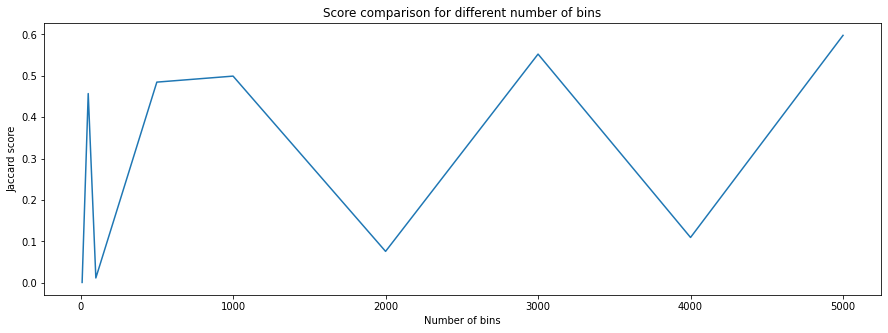

In [18]:
# experient with more bin sizes

bin_sizes = [10, 50, 100, 500, 1000, 2000, 3000, 4000, 5000]
scores = [apply_min_lsh(ip_3gram_profiles, ip_3gram_profiles.keys(), indices_true_nn, bin_size) for bin_size in bin_sizes]

_, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(bin_sizes, scores)
ax.set_xlabel('Number of bins')
ax.set_ylabel('Jaccard score')
ax.set_title('Score comparison for different number of bins')
plt.show()

### 3b. Analysis and answers to the questions

To run minwise locality sensitive hashing, we first create a dicitonary of IP connection (soruce, destination).
Each IP pair corresponds to a binary 3gram profile, which is a list of 1s and 0s. 1 means that a 3gram sequence was present for that pair, and 0 means it wasnt.
Because computing the true nearest neighbor with the profile itself took too long (>10min), we hashed the profiles to optimise the runtime, using Pythons built-in hash function.

Afterwards we run minwise LSH, by first transforming the vector into a string, and then using MD5 with a custom bin size.
We experiment with different bin sizes, compute the NearestNeighbors for minwise LSH scores, and use the Jaccard similarity score to compare against the true nearest neighbor.

The results of the experiment can be seen in the plot above. 
As can be seen, the score doesnt always increase with a larger bin size, achieving good values for as low as 50 bins. This shows that minwise LSH can be used even with a low bin size, and that choosing the correct bin size and hash function is more important than choosing a bigger one.

The performance is of course lower than computing the nearest neighbor directly, however the run-time is also much lower: 7.8 seconds versus 10+ minutes. The space requirement is lower as well,
since you only need to store the hash of a profile and not whole profile itself.


In [25]:
# experiment - two infected hosts vs one benign host
inf_host1_prof = []
inf_host2_prof = []
benign_host_prof = []

for key in ip_3gram_profiles.keys():
    if key[0] == '147.32.84.165':
        inf_host1_prof.append(key)
    elif key[0] == '147.32.84.191':
        inf_host2_prof.append(key)
    elif key[0] == '147.32.86.135' and len(benign_host_prof) < 4:
        benign_host_prof.append(key)

inf1_scores = min_lsh(ip_3gram_profiles, inf_host1_prof, 3000)
inf2_scores = min_lsh(ip_3gram_profiles, inf_host2_prof, 3000)
benign_scores = min_lsh(ip_3gram_profiles, benign_host_prof, 3000)

print('Unique minwise lsh values for infected host 1:', np.sort(np.unique(inf1_scores)))
print('Unique minwise lsh values for infected host 2:', np.sort(np.unique(inf2_scores)))
print('Unique minwise lsh values for random benign host:', np.unique(benign_scores))

Unique minwise lsh values for infected host 1: [1196 1484 1570 2090]
Unique minwise lsh values for infected host 2: [1196 1365 1570 2090]
Unique minwise lsh values for random benign host: [ 118  715 2090]


In the above experiment, we choose two infected hosts and one benign one, and use minwise lsh on 4 of their profiles (when those hosts were the source ip), with a bin size of 100.

We can see that the two infected hosts have 3 out of 4 common values, while only matching 1 with the benign one. Thus, minwise LSH can be useful when identifying botnet hosts as well, especially if we already know how a botnet profile looks like.


## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting
#### 4.a.1 Scenario 10

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpiuxmoxlu.csv --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10 --debug=1
0 Using heuristic alergia
Creating apta using evaluation class alergia
batch mode selected
 m45.8507  m7.73728  x902  m14.081  m8.78501  x219  m8.62036  m1.40064  m0  m0  m0  m0  m0  m0  m0 no more possible merges
 unknown column 0
starting greedy merging
deleted merger

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmp2nr86_4c.csv --mode=predict --aptafile=/var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpiuxmoxlu.csv.ff.final.json --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10 --debug=1
0 Using heuristic alergia
Creating apta using evaluation class alergia
predict mode selected
 unknown column 0
reading apta file - /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpiuxmoxlu.csv.ff.final.json
deleted merger

Running:  flexfringe /var/folders/q0/l_nfq0f1

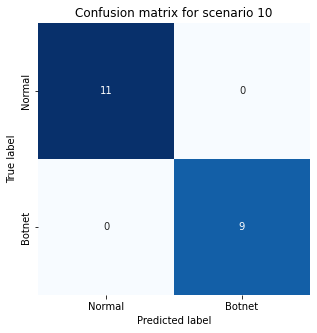

In [20]:
# plot confusion matrix
def plot_cm(y_true, y_pred, scenario):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = ['Normal', 'Botnet']
    mat = [[tn, fp], [fn, tp]]
    plt.figure(figsize=[5,5])
    plt.title('Confusion matrix for scenario ' + str(scenario))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

def get_normal_hosts(df):
    normal_labels = list(filter(lambda x: "Normal" in x, df['Label'].unique()))
    df_benign = df[df['Label'].isin(normal_labels)]
    return df_benign['SrcAddr'].unique()

# use flexfringe to create a count-based profile for a host
def create_flexfringe_ip_profile(df_flex):
    df_flex = pd.DataFrame({'id':df_flex['SrcAddr'], 'type': df_flex['Label'], 'symb': df_flex[comb_col_name]})
    flexfringe = FlexFringe(
        flexfringe_path=flexfringe_path,
        heuristic_name="alergia",
        data_name="alergia_data",
        slidingwindow=1,
        swsize=10,
        debug=1,
    )
    flexfringe.fit(df_flex)
    df_pred = flexfringe.predict(df_flex)
    symbols = df_pred['abbadingo trace']
    states = df_pred['state sequence']

    # count state-symbol pairs to create a profile
    counts = {}
    for state, symbol in zip(states, symbols):
        key = str(symbol) + '_' + str(state)
        if key in counts:
            counts[key] += 1
        else:
            counts[key] = 1

    return list(counts.values())

# compute cosine scores for all hosts in host_list against the given botnet_profile
def compute_host_scores(input_df, host_list, botnet_profile):
    scores = []
    for host in host_list:
        if host != botnet_host:
            df_host = input_df[input_df['SrcAddr'] == host].reset_index(drop=True)
            # we had to only use datasets with more than 200 rows, otherwise flexfringe gave us a segmentation fault
            if len(df_host.index) <= 200:
                continue
            profile = create_flexfringe_ip_profile(df_host)
            temp = botnet_profile.copy()
            # adjust list sizes, pad with zeroes
            if len(profile) < len(botnet_profile):
                profile += [0] * abs(len(profile) - len(botnet_profile))
            elif len(profile) > len(botnet_profile):
                temp += [0] * abs(len(profile) - len(botnet_profile))
            # calculate score using cosine distance
            scores.append(cosine(profile, temp))
    return scores

# evaluate for a scenario
def eval_flex(df, botnet_profile_ip, infected_hosts, benign_hosts, threshold, scenario):
    df_botnet_host = df[df['SrcAddr'] == botnet_profile_ip].reset_index(drop=True)
    # create profile for one botnet host
    botnet_profile = create_flexfringe_ip_profile(df_botnet_host)
    # test against other botnet hosts
    botnet_scores = compute_host_scores(df, infected_hosts, botnet_profile)
    # test against normal hosts
    benign_scores = compute_host_scores(df, benign_hosts, botnet_profile)
    print('Botnet scores', botnet_scores)
    print('Normal host scores', benign_scores)
    all_scores = botnet_scores + benign_scores
    y_true = [1] * len(botnet_scores) + [0] * len(benign_scores)
    y_pred = [1 if x < threshold else 0 for x in all_scores]
    plot_cm(y_true, y_pred, scenario)

botnet_host = '147.32.84.165'
eval_flex(df, botnet_host, infected_hosts, get_normal_hosts(df), 0.911, 10)

#### Other scenarios

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpfufx3t3n.csv --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10 --debug=1
0 Using heuristic alergia
Creating apta using evaluation class alergia
batch mode selected
 m3.78821  m11.7472  m11.7456  m6.20805  m3.08093  m3.0405  m0  m0  m0  m0  m0  m0 no more possible merges
 unknown column 0
starting greedy merging
deleted merger

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmp6uyz7pit.csv --mode=predict --aptafile=/var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpfufx3t3n.csv.ff.final.json --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10 --debug=1
0 Using heuristic alergia
Creating apta using evaluation class alergia
predict mode selected
 unknown column 0
reading apta file - /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpfufx3t3n.csv.ff.final.json
deleted merger

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp4

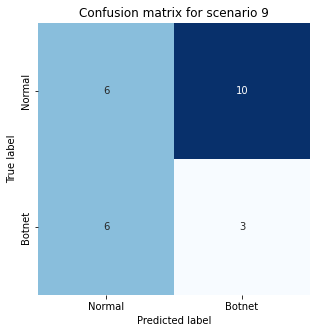

In [21]:
features = ['TotPkts', 'Dur']
comb_col_name = features[0] + '_' + features[1]

def create_comboined_feature(input_df):
    features_combined = np.zeros(len(input_df[[features[0]]]))
    for i in range(len(features)):
        discretizer = KBinsDiscretizer(n_bins=12, strategy='uniform', encode='ordinal')
        df_feature = input_df[[features[i]]].to_numpy()
        bins = discretizer.fit_transform(df_feature)[:, 0]
        vectorizer = np.vectorize(lambda x: int(discretizer.bin_edges_[0][int(x)]))
        feature_discretized = vectorizer(bins)
        if i == 0:
            features_combined = list(map(str, feature_discretized))
        else:
            temp = list(map(str, feature_discretized))
            for j in range(len(features_combined)):
                features_combined[j] += temp[j]
    input_df[comb_col_name] = features_combined
    return input_df

df_9 = pd.read_csv("data/dataset_9/capture20110817.binetflow")
df_9 = create_comboined_feature(df_9)
benign_hosts = get_normal_hosts(df_9)
eval_flex(df_9, botnet_host, infected_hosts, benign_hosts, 0.997, 9)

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpceg85540.csv --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10 --debug=1
0 Using heuristic alergia
Creating apta using evaluation class alergia
batch mode selected
 m39.3248  m6.20888  m0 no more possible merges
 unknown column 0
starting greedy merging
deleted merger

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpjbxjoaau.csv --mode=predict --aptafile=/var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpceg85540.csv.ff.final.json --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10 --debug=1
0 Using heuristic alergia
Creating apta using evaluation class alergia
predict mode selected
 unknown column 0
reading apta file - /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpceg85540.csv.ff.final.json
deleted merger

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmps00bbxow.csv --heuristic_name=alergia --data_na

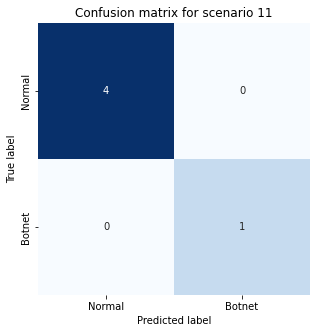

In [22]:
df_11 = pd.read_csv("data/dataset_11/capture20110818-2.binetflow")
df_11 = create_comboined_feature(df_11)
eval_flex(df_11, botnet_host, infected_hosts, get_normal_hosts(df_11), 0.96, 11)

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmp4utt0t1t.csv --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10 --debug=1
0 Using heuristic alergia
Creating apta using evaluation class alergia
batch mode selected
 m18.9688  m0  m0  m0  m0  m0  m0  m0  m0  m0 no more possible merges
 unknown column 0
starting greedy merging
deleted merger

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmp27y44dds.csv --mode=predict --aptafile=/var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmp4utt0t1t.csv.ff.final.json --heuristic_name=alergia --data_name=alergia_data --slidingwindow=1 --swsize=10 --debug=1
0 Using heuristic alergia
Creating apta using evaluation class alergia
predict mode selected
 unknown column 0
reading apta file - /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmp4utt0t1t.csv.ff.final.json
deleted merger

Running:  flexfringe /var/folders/q0/l_nfq0f150jd0mh72n5gypp40000gn/T/tmpwxjyoam5.csv --heuristic_

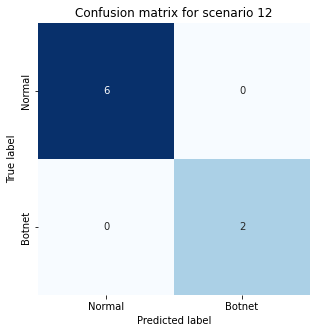

In [23]:
df_12 = pd.read_csv("data/dataset_12/capture20110819.binetflow")
df_12 = create_comboined_feature(df_12)
eval_flex(df_12, botnet_host, infected_hosts, get_normal_hosts(df_12), 0.1, 12)

### 4b. Analysis and answers to the questions.

For this task, we first create a dataframe containing only one host, and run flex-fringe in order to create a Deterministic Finite Automaton.
Afterwards we count the occurences of each state-symbol pair. Thus, we create a profile for our chosen botnet host.

Following this, we create profiles for other botnet as well as normal hosts from the same scenario, and compute the cosine distance between the chosen botnet host and others. We then manually set a threshold and plot the confusion matrix. We repeat the experiment for each scenario.

As can be seen from the matrices, with the right threshold, it is possible to distinguish between normal and botnet hosts, exception being scenario nine, where the scores for both botnet and normal are quite similar. Perhaps choosing another botnet host would have yielded a different result.

We also had a weird error from flexfringe, where it would give us a segmentation fault if we used a dataframe with less than ~200 rows as input, which is why we had to not run the algorithm on those hosts.

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.